In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [3]:
# read Covid-19 SG dataset

sg_data = pd.read_csv(url)

In [4]:
# filter to include only columns A to AD

sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

**Outliers will not be removed because of their importance in the Covid context.**

**No need for scaling as all features are of the same magnitude.**

**Can look into what other features can be included from the current ones through extrapolation.**

In [5]:
sg_data_filtered.head()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
0,2020-01-23,1,NaN,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,2,NaN,3,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,1,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,0,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,1,NaN,5,0,0,0,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          635 non-null    object 
 1   Daily Confirmed                               635 non-null    int64  
 2   False Positives Found                         526 non-null    float64
 3   Cumulative Confirmed                          635 non-null    int64  
 4   Daily Discharged                              635 non-null    int64  
 5   Passed but not due to COVID                   635 non-null    int64  
 6   Cumulative Discharged                         635 non-null    int64  
 7   Discharged to Isolation                       635 non-null    int64  
 8   Still Hospitalised                            635 non-null    int64  
 9   Daily Deaths                                  635 non-null    int

In [7]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [8]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [9]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)

In [10]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [11]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [12]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [13]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               635 non-null    int64  
 1   False Positives Found                         635 non-null    float64
 2   Cumulative Confirmed                          635 non-null    int64  
 3   Daily Discharged                              635 non-null    int64  
 4   Passed but not due to COVID                   635 non-null    int64  
 5   Cumulative Discharged                         635 non-null    int64  
 6   Discharged to Isolation                       635 non-null    int64  
 7   Still Hospitalised                            635 non-null    int64  
 8   Daily Deaths                                  635 non-null    int64  
 9   Cumulative Deaths                             635 non-null    int

<AxesSubplot:>

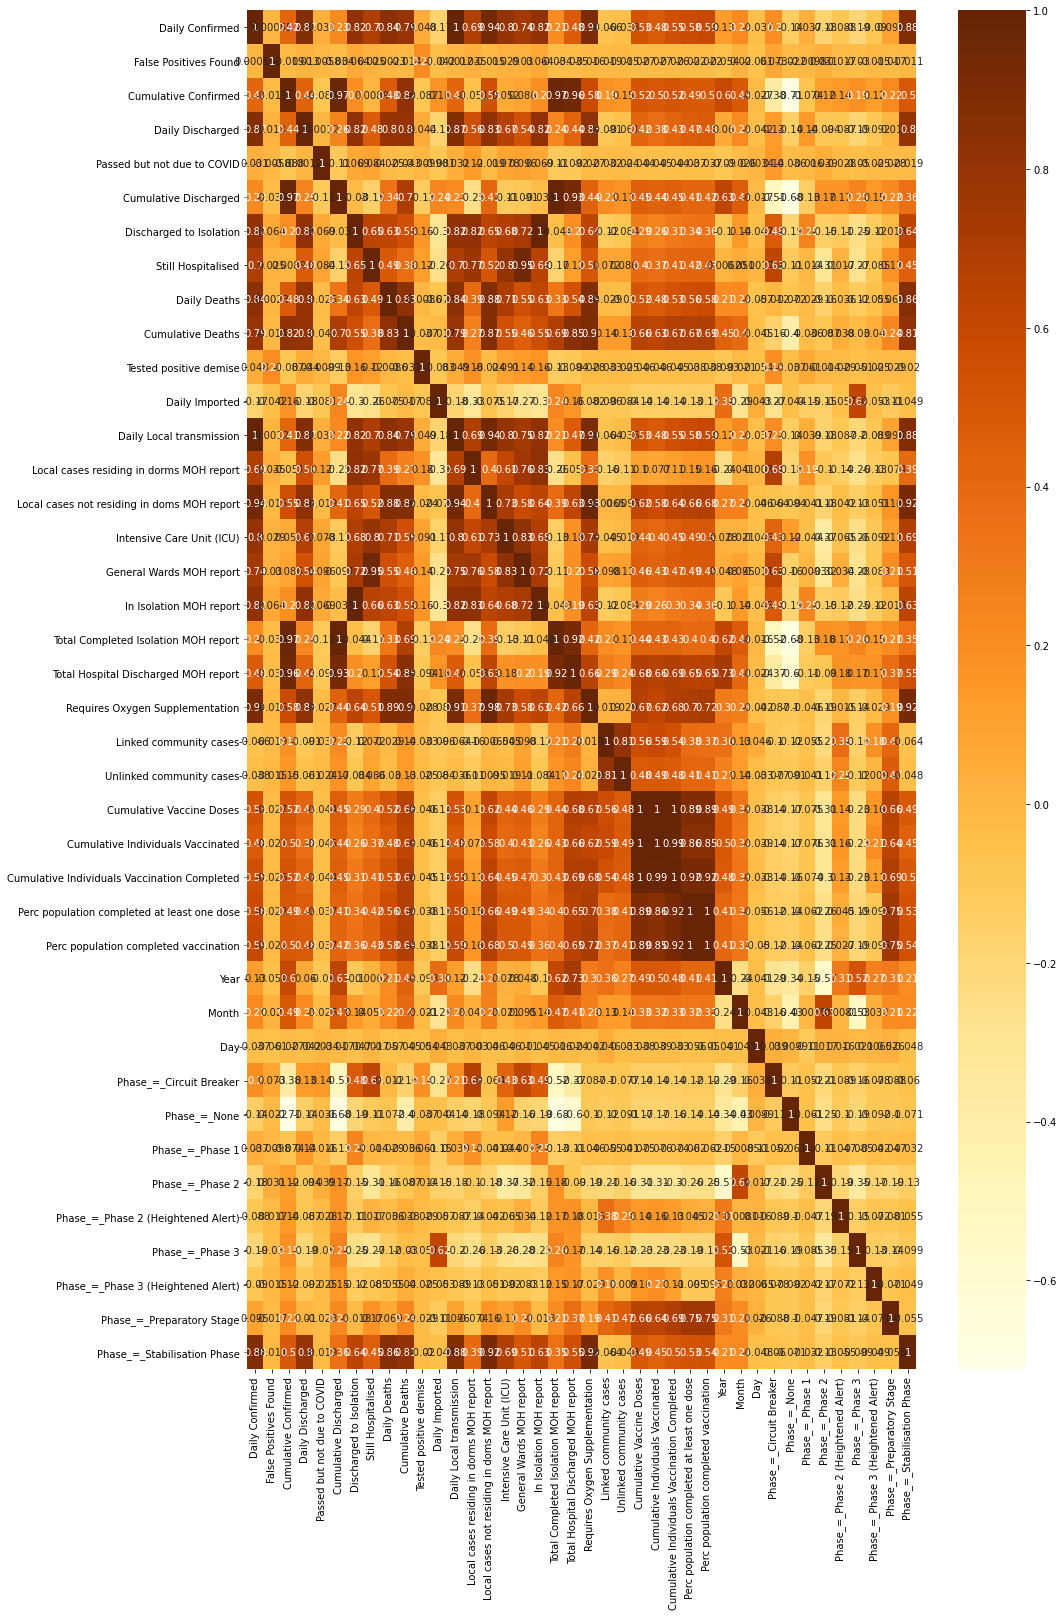

In [14]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [15]:
# understanding correlation of all variables to imported cases (can change accordingly to the variable you are trying to predict)

sg_data_filtered.corr()["Daily Imported"].sort_values(ascending=False)

Daily Imported                                  1.000000
Phase_=_Phase 3                                 0.624419
Year                                            0.378943
Total Completed Isolation MOH report            0.243384
Cumulative Discharged                           0.239234
Cumulative Confirmed                            0.164685
Total Hospital Discharged MOH report            0.160471
Day                                             0.042699
Cumulative Deaths                              -0.017243
False Positives Found                          -0.042476
Phase_=_None                                   -0.044044
Phase_=_Stabilisation Phase                    -0.049402
Phase_=_Phase 3 (Heightened Alert)             -0.053168
Phase_=_Phase 2 (Heightened Alert)             -0.057083
Local cases not residing in doms MOH report    -0.074594
Daily Deaths                                   -0.075403
Passed but not due to COVID                    -0.081405
Requires Oxygen Supplementation

In [16]:
# conduct PCA on preprocessed columns

# pca = PCA().fit(sg_data_filtered)

In [17]:
# pca.components_[0]

In [18]:
# find index of columns that make most contribution to variance captured

# include index of Daily Imported first
# important_indices = [11]

# for i in range(len(pca.components_[0])):
#     curr_comp = pca.components_[0][i]
#     if curr_comp > 0.0001:
#         important_indices.append(i)

In [19]:
# select the columns that are positively correlated to imported cases + PCA columns

# sg_data_final = sg_data_filtered.iloc[:, important_indices]

# Train Test Split & K Fold Cross Validation

In [20]:
# change y variable accordingly to what is of interest

X = sg_data_filtered.drop("Daily Imported", axis=1)
y = sg_data_filtered["Daily Imported"]

In [21]:
# split using 20% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [22]:
# K Fold Stratified with 5 folds

strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Linear Regression

In [23]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [24]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(regression, X, y, cv=strat_k_fold)), 4)}")

Evaluation Metrics for LR
MAE: 3.653789506415768e-11
MSE: 3.686419736827592e-21
RMSE: 6.071589360972622e-11
R-squared score for train: 1.0
Adjusted R-squared score for train: 1.0
R-squared score for test: 1.0
Adjusted R-squared score for test: 1.0
Cross Validation Score: 1.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


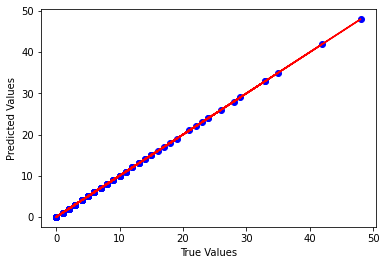

In [25]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

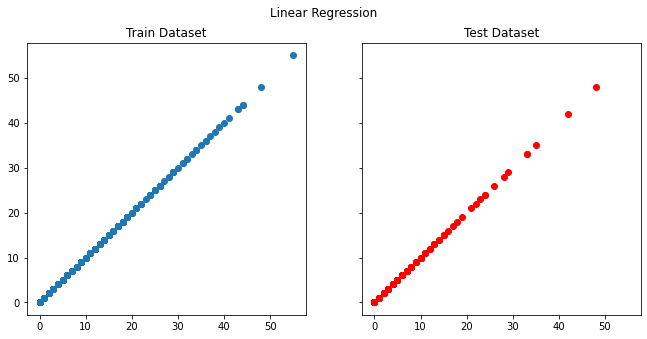

In [26]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [27]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
0,Daily Confirmed,1.000000e+00
2,Cumulative Confirmed,5.120151e-11
8,Daily Deaths,2.892175e-11
4,Passed but not due to COVID,2.518441e-11
1,False Positives Found,1.162429e-11
26,Perc population completed vaccination,1.563664e-12
21,Unlinked community cases,1.428979e-12
35,Phase_=_Phase 3,1.078131e-12
27,Year,7.663776e-13
18,Total Hospital Discharged MOH report,8.007836e-14


# Ridge Regression

In [28]:
# build ridge model

ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.38323e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [29]:
# assessing model

train_adjusted_r2 = 1 - (1-ridge.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-ridge.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Ridge")
print(f"MAE: {mean_absolute_error(y_test, ridge_pred)}")
print(f"MSE: {mean_squared_error(y_test, ridge_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ridge_pred))}")
print(f"R-squared score for train: {ridge.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {ridge.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")
print(f"Cross Validation Score: {round(np.mean(cross_val_score(ridge, X, y, cv=strat_k_fold)), 4)}")

Evaluation Metrics for Ridge
MAE: 0.0007528492557971799
MSE: 1.4850939538298517e-06
RMSE: 0.001218644309808999
R-squared score for train: 0.9999999819461033
Adjusted R-squared score for train: 0.9999999807627387
R-squared score for test: 0.9999999816495364
Adjusted R-squared score for test: 0.9999999804467329
Cross Validation Score: 1.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.11862e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.82976e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.0092e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.80264e-17

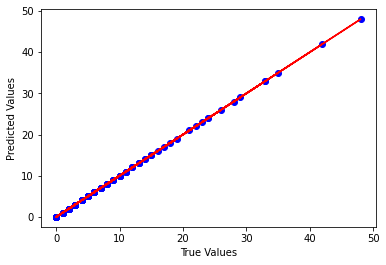

In [30]:
# For test set

# scatter for predictions
plt.scatter(y_test, ridge_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

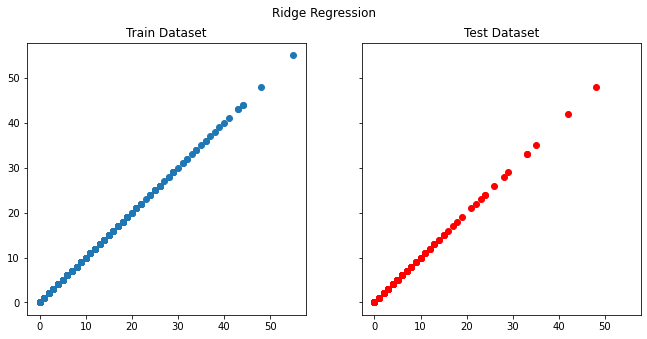

In [31]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(ridge.predict(X_train), y_train)
ax[1].scatter(ridge_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Ridge Regression')

plt.show()

In [32]:
# find out feature importance

ridge_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': ridge.coef_
})

ridge_importance = ridge_importance.sort_values(by='Importance', ascending=False)
ridge_importance

,Attribute,Importance
0,Daily Confirmed,9.998430e-01
35,Phase_=_Phase 3,1.456038e-03
30,Phase_=_Circuit Breaker,4.408905e-04
33,Phase_=_Phase 2,3.246621e-04
8,Daily Deaths,1.352216e-04
32,Phase_=_Phase 1,1.305197e-04
26,Perc population completed vaccination,8.188515e-05
25,Perc population completed at least one dose,6.896570e-05
2,Cumulative Confirmed,3.302991e-05
18,Total Hospital Discharged MOH report,7.345552e-06
